# Lab 4 - Information Processing and Retrieval

## Document organizing, annotation, ranking

In [1]:
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.graphics', 'rec.autos', 'sci.crypt', 'talk.politics.guns']
collection = fetch_20newsgroups(subset='test', categories=categories)

In [2]:
for i in range(2):
    print(collection.data[i])
    print(collection.target[i])
    print(collection.target_names[collection.target[i]])
    print()

From: holland@CS.ColoState.EDU (douglas craig holland)
Subject: What would happen if export restrictions violated?
Nntp-Posting-Host: beethoven.cs.colostate.edu
Organization: Colorado State University, Computer Science Department
Lines: 15


OK, I heard a lot of talk about the NSA's infamous control over encryption
export through the ITAR.  Here's a question.  Say I develop this great new
encryption system, and I want to sell my software worldwide.  The thought
police then come in and say "This algorithm is a threat to national security.
You will not be permitted to export it."  At this point, what kind of trouble
could I get into if I ignored the ITAR and sold my program to international
customers anyway?

Doug Holland

-- 
|  Doug Holland                | Anyone who tries to take away my freedom  |
|  holland@cs.colostate.edu    | of speech will have to pry it from my     |
|  PGP key available by E-mail | cold, dead lips!!                         |

2
sci.crypt

From: strnlght@netco

Since data is in a text format, we need to process it in order to extract useful information. Let's use TFIDF from scikit-learn

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=False)

X = vectorizer.fit_transform(collection.data)

In [4]:
print(X.shape)

(1545, 26904)


In [5]:
print(vectorizer.get_feature_names_out())

['00' '000' '0000' ... 'zyda' 'zyeh' 'zyxel']


# 1 Cluster the collection

1.1. Extract the vector space of the 20 Newsgroup (use collection.data instruction to ignore
the class variable), and cluster the collection using agglomerative clustering from scikit-learn

In [20]:
from sklearn.cluster import AgglomerativeClustering



clustering = AgglomerativeClustering().fit(X.toarray())

# Note: we convert X to an array because it's needed by AgglomerativeClustering


In [7]:
print(clustering.labels_)

[0 0 0 ... 0 1 0]


In [8]:
# Print all distinct labels
print(set(clustering.labels_))

{0, 1}


Try to parameterize the number of clusters and the linkage method. 

In [29]:

n_clusters = len(categories)
# choose the best number for n_clusters
single = AgglomerativeClustering(linkage='single', n_clusters=n_clusters, metric='cosine').fit(X.toarray())
complete = AgglomerativeClustering(linkage='complete', n_clusters=n_clusters, metric='cosine').fit(X.toarray())

In [30]:
single_labels = single.labels_
complete_labels = complete.labels_

In [31]:
print(single_labels)
print(complete_labels)

[0 0 0 ... 0 0 0]
[1 3 1 ... 3 1 3]


1.2. Plot the learned dendogram using the cluster.hierarchy.dendrogram package from scipy.
Compare the clustering solutions produced under single and complete linkage criteria.

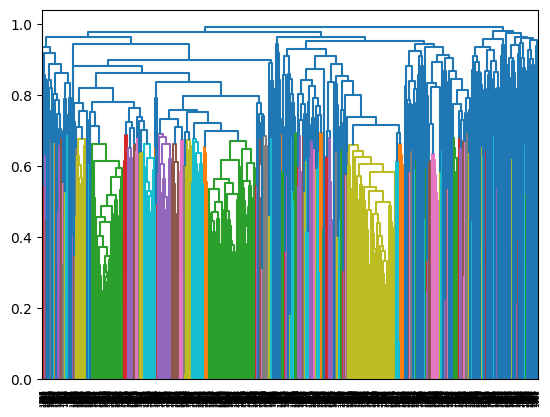

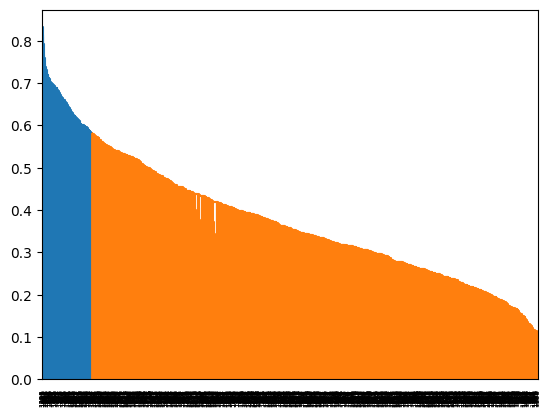

In [40]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Z = linkage(X.toarray(), method='complete', metric='cosine')

plt.figure()
dendrogram(Z)
plt.show()

Z = linkage(X.toarray(), method='single', metric='cosine')

plt.figure()
dendrogram(Z)
plt.show()



1.3. Evaluate the clustering solution by computing an internal measure (e.g. silhouette) and an
external measure (e.g. adjusted rand index) for the produced clustering solution.

In [41]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
sscore = silhouette_score(X, single_labels, metric='cosine')
cscore = silhouette_score(X, complete_labels, metric='cosine')

# for the random score we need the true labels
true_labels = collection.target

arsingle = adjusted_rand_score(true_labels, single_labels)
arcomplete = adjusted_rand_score(true_labels, complete_labels)

print(f"Silhouette score for single linkage: {sscore}")
print(f"Silhouette score for complete linkage: {cscore}")
print(f"Adjustewd Rand score for single linkage: {arsingle}")
print(f"Adjusted Rand score for complete linkage: {arcomplete}")


Silhouette score for single linkage: 0.26392018268553363
Silhouette score for complete linkage: 0.02735054639193526
Adjustewd Rand score for single linkage: -3.059877070379207e-05
Adjusted Rand score for complete linkage: 0.015177362174200237


1.4. (homework) Principal component analysis (PCA), latent semantic indexing (LSI) and uMAP
procedures offer a way of projecting our high-dimensional vector space into a space with lower
dimensionality. Map the original space into a 2-dimensional space, plotting the documents in
this new space. Color the documents according to their cluster to assess their separation

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
new_X = pca.fit_transform(X.toarray())

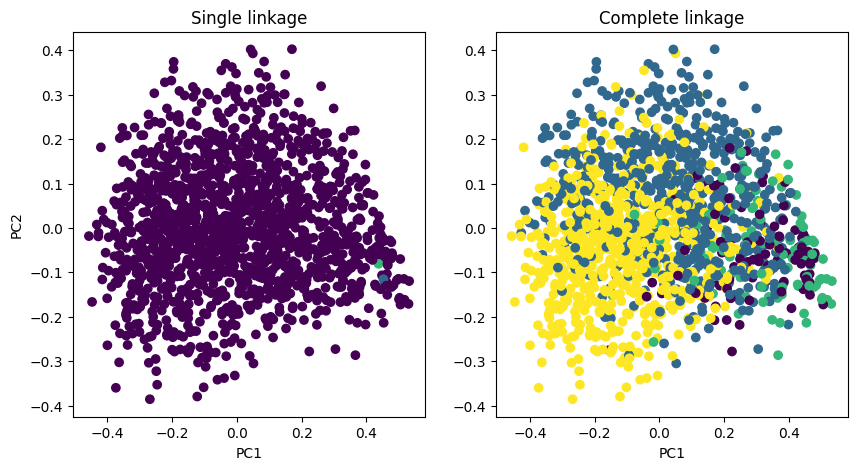

In [44]:
plt.figure(figsize=(10, 5))

# Plotting PCA
plt.subplot(1, 2, 1)
plt.scatter(new_X[:, 0], new_X[:, 1], c=single_labels, cmap='viridis')
plt.title('Single linkage')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 2, 2)
plt.scatter(new_X[:, 0], new_X[:, 1], c=complete_labels, cmap='viridis')
plt.title('Complete linkage')
plt.xlabel('PC1')

plt.show()

### 2 Document classification in the 20 NewsGroup

In [45]:
# Split the 20news dataset into training and testing sets

from sklearn.datasets import fetch_20newsgroups
train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='test')

In [46]:
# Vect
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=False)
trainvec = vectorizer.fit_transform(train.data)
testvec = vectorizer.transform(test.data)

In [48]:
# Print the label numeric and the label name
print(train.target[0])
print(train.target_names[train.target[0]])


7
rec.autos


In [53]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
classifier = MultinomialNB()
classifier.fit(trainvec, train.target)

classes = classifier.predict(testvec)

In [54]:
# Evaluation
from sklearn import metrics

print(metrics.accuracy_score(test.target, classes))
print(metrics.classification_report(test.target, classes, target_names=test.target_names))

0.7052575677110993
                          precision    recall  f1-score   support

             alt.atheism       0.85      0.24      0.37       319
           comp.graphics       0.71      0.60      0.65       389
 comp.os.ms-windows.misc       0.79      0.65      0.71       394
comp.sys.ibm.pc.hardware       0.63      0.75      0.69       392
   comp.sys.mac.hardware       0.86      0.68      0.76       385
          comp.windows.x       0.88      0.68      0.77       395
            misc.forsale       0.90      0.72      0.80       390
               rec.autos       0.71      0.92      0.80       396
         rec.motorcycles       0.84      0.91      0.87       398
      rec.sport.baseball       0.86      0.85      0.86       397
        rec.sport.hockey       0.90      0.93      0.91       399
               sci.crypt       0.52      0.96      0.67       396
         sci.electronics       0.78      0.52      0.63       393
                 sci.med       0.82      0.76      0.79 

2.2. Try to improve the classification by:
(a) Removing very rare words (e.g. words that occur less than 2 times) or very frequent words
(e.g. words that occur in more than 90% documents) using Vectorizer utils by scikit-learn

In [58]:
# Remove very rare words usign Vectorizer utils

maxes = [80,85,90,95]
mines = [2,5,10,20]

bestmax = 0
bestmin = 0

bestscore = 0

for max in maxes:
    for min in mines:
        vectorizer = TfidfVectorizer(use_idf=False, max_df=max, min_df=min)
        trainvec = vectorizer.fit_transform(train.data)
        testvec = vectorizer.transform(test.data)
        classifier = MultinomialNB()
        classifier.fit(trainvec, train.target)
        classes = classifier.predict(testvec)
        score = metrics.accuracy_score(test.target, classes)
        if score > bestscore:
            bestscore = score
            bestmax = max
            bestmin = min

print(f"Best score: {bestscore}")
print(f"Best max: {bestmax}")
print(f"Best min: {bestmin}")






Best score: 0.7731014338821031
Best max: 90
Best min: 2


In [59]:
# Compare with KNN, perceptron and svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC

# Keep the best vectorizer

vectorizer = TfidfVectorizer(use_idf=False, max_df=90, min_df=2)

scores = {}

trainvec = vectorizer.fit_transform(train.data)
testvec = vectorizer.transform(test.data)

# KNN
knn = KNeighborsClassifier()
knn.fit(trainvec, train.target)
classes = knn.predict(testvec)
scores['KNN'] = metrics.accuracy_score(test.target, classes)

# Perceptron
perceptron = Perceptron()
perceptron.fit(trainvec, train.target)
classes = perceptron.predict(testvec)
scores['Perceptron'] = metrics.accuracy_score(test.target, classes)

# SVM
svm = SVC()
svm.fit(trainvec, train.target)
classes = svm.predict(testvec)
scores['SVM'] = metrics.accuracy_score(test.target, classes)



{'KNN': 0.602761550716941, 'Perceptron': 0.7267657992565055, 'SVM': 0.7320764737121614}


In [60]:
scores['Naive Bayes'] = bestscore
print(scores)

{'KNN': 0.602761550716941, 'Perceptron': 0.7267657992565055, 'SVM': 0.7320764737121614, 'Naive Bayes': 0.7731014338821031}


3 Learning to Rank
Let us create a ranking method that linearly combines results from different scoring functions

score(q, d) = α1bm25(q, d) + α2cos(q, d) + α3f req(q, d)

where d is the document, q is the query, bm25 is the score obtained using the BM25 ranking
function, cos is the score obtained using the TF IDF ranking function, and f req is the score
obtained using the Term Frequency ranking function.

In [61]:

def bm25(q,d):
    k = 1.2
    b = 0.75
    score = 0
    for term in q:
        if term in d:
            idf = 1
            tf = 1
            score += (idf * tf * (k + 1)) / (tf + k * (1 - b + b * len(d) / 100))
    return score

# TF_IDF Ranking function
def tfidf(q,d, useidf=True):
    text = [''.join(q), ''.join(d)]

    vectorizer = TfidfVectorizer(use_idf=useidf)

    tfidfvals = vectorizer.fit_transform(text)

    features = vectorizer.get_feature_names_out()

    dvec = tfidfvals.toarray()[1]

    score = 0
    for term in q:
        if term in features:
            index = list(features).index(term)
            score+=dvec[index]

    return score

def score(q,d):
    bm25score = bm25(q,d)
    tfidfscore = tfidf(q,d)
    tfscore = tfidf(q,d, False)

    alpha1 = 0.5
    alpha2 = 0.3
    alpha3 = 0.2

    score = alpha1 * bm25score + alpha2 * tfidfscore + alpha3 * tfscore

    return score
    
    

In [ ]:
# test this stuff
